In [ ]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

### Preprocessing (acoustic)

In [ ]:
import os
import torch
import torchaudio
import librosa
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import soundfile as sf

# ✅ Set device for GPU processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Define Paths
dataset_path = r"C:\Speech_Processing\Project\2speakers"
output_path = r"C:\Speech_Processing\Project\Output_2\preprocessed_audio"
os.makedirs(output_path, exist_ok=True)

# ✅ Function to load & resample audio (on CPU)
def load_audio(file_path, target_sr=16000):
    """Load audio & resample to target sample rate (CPU)."""
    audio, sr = librosa.load(file_path, sr=None)
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    return torch.tensor(audio, dtype=torch.float32).to(device), target_sr  # Move to GPU

# ✅ Function for normalization (GPU)
def normalize_audio(audio):
    """Normalize audio to range [-1, 1] (GPU)."""
    return audio / torch.max(torch.abs(audio))

# ✅ Function for wavelet denoising using Wiener filter (CPU)
def wavelet_denoise(audio):
    """Apply Wiener filter for noise reduction (CPU)."""
    audio_cpu = audio.cpu().numpy()  # Move to CPU for processing
    denoised_audio = scipy.signal.wiener(audio_cpu)
    return torch.tensor(denoised_audio, dtype=torch.float32).to(device)  # Move back to GPU

# ✅ Function to compute Mel-Spectrogram (GPU)
def compute_mel_spectrogram(audio, sr):
    """Generate Mel-Spectrogram using GPU."""
    audio = audio.unsqueeze(0)  # Ensure batch dimension [1, N]
    
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,  # Set FFT size
        hop_length=512,  # Hop size
        n_mels=128  # Number of Mel bins
    ).to(device)
    
    mel_spec = mel_transform(audio)  # Compute Mel-Spectrogram
    mel_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)  # Convert to dB
    return mel_db.squeeze(0)  # Remove batch dim

# ✅ Function to compute MFCCs (GPU)
def compute_mfcc(audio, sr):
    """Compute MFCCs using GPU."""
    audio = audio.unsqueeze(0)  # Ensure batch dimension [1, N]
    
    mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=sr, 
        n_mfcc=13, 
        melkwargs={"n_fft": 1024, "hop_length": 512, "n_mels": 128}  # ✅ CORRECTED melkwargs
    ).to(device)

    mfcc = mfcc_transform(audio)
    return mfcc.squeeze(0)  # Remove batch dim

# ✅ Process each sample
for i, folder in enumerate(sorted(os.listdir(dataset_path), key=lambda x: int(x.split("_")[1])), start=1):
    if folder.startswith("sample_") and os.path.isdir(os.path.join(dataset_path, folder)):
        sample_folder = os.path.join(dataset_path, folder)
        mixture_path = os.path.join(sample_folder, "mixture.wav")

        # Check if mixture.wav exists
        if os.path.exists(mixture_path):
            print(f"🔹 Processing {mixture_path}...")

            # ✅ Load and preprocess Mixture Audio
            mixture_audio, sr = load_audio(mixture_path)  # Load to GPU
            mixture_audio = normalize_audio(mixture_audio)
            mixture_audio = wavelet_denoise(mixture_audio)

            # ✅ Extract Acoustic Features (Keep on GPU)
            mel_spec = compute_mel_spectrogram(mixture_audio, sr)
            mfcc = compute_mfcc(mixture_audio, sr)

            # ✅ Save Preprocessed Audio (Move to CPU for saving)
            processed_audio_path = os.path.join(output_path, f"sample_{i}_preprocessed.wav")
            sf.write(processed_audio_path, mixture_audio.cpu().numpy(), sr)

            # ✅ Save Mel-Spectrogram as PNG
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mel_spec.cpu().numpy(), sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format="%+2.0f dB")
            plt.title(f"Sample {i} - Mel Spectrogram")
            plt.savefig(os.path.join(output_path, f"sample_{i}_mel_spectrogram.png"))
            plt.close()

            # ✅ Save MFCC as PNG
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mfcc.cpu().numpy(), sr=sr, x_axis='time')
            plt.colorbar()
            plt.title(f"Sample {i} - MFCCs")
            plt.savefig(os.path.join(output_path, f"sample_{i}_mfcc.png"))
            plt.close()

            print(f"✅ Features extracted & saved for {folder}")



print("🚀 Preprocessing Complete. All outputs saved to:", output_path)


### Feature extraction(spatial)

In [ ]:
import os
import torch
import torchaudio
import librosa
import numpy as np
import pandas as pd
import soundfile as sf

# ✅ Set device for GPU processing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ Define Paths
dataset_path = r"C:\Speech_Processing\Project\2speakers"
output_path = r"C:\Speech_Processing\Project\Output_2\spatial_features"
os.makedirs(output_path, exist_ok=True)

# ✅ Function to load & resample audio
def load_audio(file_path, target_sr=16000):
    """Load audio & resample to target sample rate."""
    audio, sr = librosa.load(file_path, sr=None)
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    return torch.tensor(audio, dtype=torch.float32).to(device), target_sr  # Move to GPU

# ✅ Compute Interaural Time Difference (ITD)
def compute_itd(audio, sr):
    """Estimate ITD using energy centroid shift."""
    time_axis = torch.arange(len(audio), dtype=torch.float32, device=device) / sr  # Time vector
    energy = audio ** 2  # Compute energy
    centroid = torch.sum(time_axis * energy) / torch.sum(energy)  # Energy-weighted centroid
    return centroid.item()  # Convert to Python float

# ✅ Compute Interaural Level Difference (ILD)
def compute_ild(audio):
    """Estimate ILD in dB."""
    power = torch.mean(audio ** 2)
    ild = 10 * torch.log10(power + 1e-6)  # Avoid log(0)
    return ild.item()

# ✅ Compute Direction of Arrival (DOA)
def compute_doa(audio, sr):
    """Estimate DOA using Generalized Cross-Correlation with Phase Transform (GCC-PHAT)."""
    try:
        n = len(audio)
        X = torch.fft.rfft(audio)  # Compute FFT
        gcc_phat = torch.fft.irfft(X / (torch.abs(X) + 1e-6))  # Avoid division by zero
        max_idx = torch.argmax(torch.abs(gcc_phat))
        doa = (max_idx - n // 2) / sr
        return doa.item()
    except Exception:
        return float('nan')  # Handle errors

# ✅ Simple Beamforming (Weighted Summation)
def beamforming(audio, weights=[0.6, 0.4]):
    """Apply simple beamforming using weighted sum."""
    audio = audio.unsqueeze(0)  # Ensure batch dimension
    weights_tensor = torch.tensor(weights, dtype=torch.float32, device=device).view(-1, 1)
    beamformed_audio = torch.sum(weights_tensor * audio, dim=0)  # Weighted sum
    return beamformed_audio

# ✅ Initialize Data Storage
feature_data = []

# ✅ Process each sample
for folder in sorted(os.listdir(dataset_path), key=lambda x: int(x.split("_")[1])):
    if folder.startswith("sample_") and os.path.isdir(os.path.join(dataset_path, folder)):
        sample_id = int(folder.split("_")[1])  # Extract numerical part
        sample_folder = os.path.join(dataset_path, folder)
        mixture_path = os.path.join(sample_folder, "mixture.wav")

        if os.path.exists(mixture_path):  # Ensure the file exists
            print(f"🔹 Processing {mixture_path}...")

            # ✅ Load Mixture Audio
            mixture_audio, sr = load_audio(mixture_path)  # Load to GPU

            # ✅ Extract Spatial Features
            itd = compute_itd(mixture_audio, sr)
            ild = compute_ild(mixture_audio)
            doa = compute_doa(mixture_audio, sr)

            # ✅ Apply Beamforming
            beamformed_audio = beamforming(mixture_audio)

            # ✅ Save Beamformed Audio
            beamformed_path = os.path.join(output_path, f"sample_{sample_id}_beamformed.wav")
            sf.write(beamformed_path, beamformed_audio.cpu().numpy(), sr)

            # ✅ Store Data
            feature_data.append([f"sample_{sample_id}", itd, ild, doa])


# ✅ Convert to DataFrame and Save to CSV
df = pd.DataFrame(feature_data, columns=["Sample", "ITD", "ILD", "DOA"])
csv_path = os.path.join(output_path, "spatial_features.csv")
df.to_csv(csv_path, index=False)

print(f"✅ Spatial Feature Extraction Complete! Features saved to '{csv_path}'.")


### Model

### superformer & spaRsep

### main code model and training

In [ ]:
#train
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
import os
import librosa
import soundfile as sf
from tqdm import tqdm
import warnings
import gc
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths configuration
individual_path = r"C:\Speech_Processing\Project\2speakers"
preprocessed_path = r"C:\Speech_Processing\Project\Output_2\preprocessed_audio"
spatial_path = r"C:\Speech_Processing\Project\Output_2\spatial_features"
spatial_csv = os.path.join(spatial_path, "spatial_features.csv")

# Hyperparameters
batch_size = 8
learning_rate = 1e-4
num_epochs = 20
n_mels = 128
sr = 16000
target_length = 160000
hop_length = 512
expected_T = (target_length + hop_length - 1) // hop_length

# Custom Dataset
class AudioSeparationDataset(Dataset):
    def __init__(self, preprocessed_path, individual_path, spatial_csv):
        self.preprocessed_path = preprocessed_path
        self.individual_path = individual_path
        self.spatial_df = pd.read_csv(spatial_csv)
        self.sample_ids = [f.split('_')[1].split('.')[0] for f in os.listdir(preprocessed_path) 
                           if f.startswith('sample_') and f.endswith('_preprocessed.wav')]
        valid_ids = []
        for sample_id in self.sample_ids:
            s1_path = os.path.join(self.individual_path, f"sample_{sample_id}", "calib0.wav")
            s2_path = os.path.join(self.individual_path, f"sample_{sample_id}", "calib1.wav")
            if os.path.exists(s1_path) and os.path.exists(s2_path):
                valid_ids.append(sample_id)
            else:
                print(f"Warning: Missing calib0.wav or calib1.wav for sample_{sample_id}")
        self.sample_ids = valid_ids
        
    def __len__(self):
        return len(self.sample_ids)
    
    def _load_audio(self, path):
        try:
            audio, orig_sr = sf.read(path, dtype=np.float32)
            if audio.ndim > 1:
                audio = np.mean(audio, axis=1)
            if orig_sr != sr:
                audio = librosa.resample(audio, orig_sr=orig_sr, target_sr=sr)
            if len(audio) > target_length:
                audio = audio[:target_length]
            else:
                audio = np.pad(audio, (0, max(0, target_length - len(audio))), 'constant')
            return audio
        except Exception as e:
            print(f"Error loading audio {path}: {str(e)}")
            return np.zeros(target_length, dtype=np.float32)

    def __getitem__(self, idx):
        sample_id = self.sample_ids[idx]
        mixture_path = os.path.join(self.preprocessed_path, f"sample_{sample_id}_preprocessed.wav")
        s1_path = os.path.join(self.individual_path, f"sample_{sample_id}", "calib0.wav")
        s2_path = os.path.join(self.individual_path, f"sample_{sample_id}", "calib1.wav")
        
        mixture_audio = self._load_audio(mixture_path)
        s1_audio = self._load_audio(s1_path)
        s2_audio = self._load_audio(s2_path)
        
        try:
            mel_spec_mixture = librosa.feature.melspectrogram(y=mixture_audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
            mel_spec_s1 = librosa.feature.melspectrogram(y=s1_audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
            mel_spec_s2 = librosa.feature.melspectrogram(y=s2_audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
            mel_spec_mixture /= mel_spec_mixture.max()
            mel_spec_s1 /= mel_spec_s1.max()
            mel_spec_s2 /= mel_spec_s2.max()
            mel_spec_mixture = torch.tensor(mel_spec_mixture, dtype=torch.float32).unsqueeze(0)
            mel_spec_s1 = torch.tensor(mel_spec_s1, dtype=torch.float32)
            mel_spec_s2 = torch.tensor(mel_spec_s2, dtype=torch.float32)
            if mel_spec_s1.shape != (n_mels, expected_T) or mel_spec_s2.shape != (n_mels, expected_T):
                raise ValueError(f"Unexpected shape: s1={mel_spec_s1.shape}, s2={mel_spec_s2.shape}")
        except Exception as e:
            print(f"Error computing Mel-spectrograms for sample_{sample_id}: {str(e)}")
            mel_spec_mixture = torch.zeros(1, n_mels, expected_T, dtype=torch.float32)
            mel_spec_s1 = torch.zeros(n_mels, expected_T, dtype=torch.float32)
            mel_spec_s2 = torch.zeros(n_mels, expected_T, dtype=torch.float32)
        
        try:
            spatial_row = self.spatial_df[self.spatial_df['Sample'] == f'sample_{sample_id}'].iloc[0]
            spatial_feats = torch.tensor([spatial_row['ITD'], spatial_row['ILD'], spatial_row['DOA']], dtype=torch.float32)
        except Exception as e:
            print(f"Error loading spatial features for sample_{sample_id}: {str(e)}")
            spatial_feats = torch.zeros(3, dtype=torch.float32)
        
        del mixture_audio, s1_audio, s2_audio
        gc.collect()
        
        return mel_spec_mixture, spatial_feats, (mel_spec_s1, mel_spec_s2)

# Model Architecture
class CrossAttentionLayer(nn.Module):
    def __init__(self, acoustic_dim, spatial_dim):
        super().__init__()
        self.query = nn.Linear(acoustic_dim, acoustic_dim)
        self.key = nn.Linear(spatial_dim, acoustic_dim)
        self.value = nn.Linear(spatial_dim, acoustic_dim)
        
    def forward(self, x1, x2):
        x2 = x2.unsqueeze(1).expand(-1, x1.size(1), -1)
        q = self.query(x1)
        k = self.key(x2)
        v = self.value(x2)
        attn = torch.softmax(torch.bmm(q, k.transpose(1, 2)) / (x1.size(-1) ** 0.5), dim=-1)
        out = torch.bmm(attn, v)
        return out + x1

class Superformer(nn.Module):
    def __init__(self, n_mels=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.transformer_dim = 32 * (n_mels // 4)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.transformer_dim, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
        
    def forward(self, x):
        x = self.conv(x)
        B, C, F, T = x.shape
        x = x.permute(0, 3, 2, 1).reshape(B, T, -1)
        return self.transformer(x)

class SpaRsep(nn.Module):
    def __init__(self, spatial_dim=3, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(spatial_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.net(x)

class SeparationModel(nn.Module):
    def __init__(self, n_mels=128):
        super().__init__()
        self.superformer = Superformer(n_mels)
        self.sparsep = SpaRsep()
        self.cross_attn = CrossAttentionLayer(self.superformer.transformer_dim, 128)
        self.mask_head1 = nn.Linear(self.superformer.transformer_dim, n_mels)
        self.mask_head2 = nn.Linear(self.superformer.transformer_dim, n_mels)
        
    def forward(self, mel_spec, spatial_feats):
        acoustic_feats = self.superformer(mel_spec)
        spatial_feats = self.sparsep(spatial_feats)
        fused_feats = self.cross_attn(acoustic_feats, spatial_feats)
        mask1 = torch.sigmoid(self.mask_head1(fused_feats))
        mask2 = torch.sigmoid(self.mask_head2(fused_feats))
        return mask1, mask2

# DataLoader with collate_fn
def collate_fn(batch):
    mel_specs = torch.stack([item[0] for item in batch])
    spatial_feats = torch.stack([item[1] for item in batch])
    targets_s1 = torch.stack([item[2][0] for item in batch])
    targets_s2 = torch.stack([item[2][1] for item in batch])
    return mel_specs, spatial_feats, (targets_s1, targets_s2)

# SI-SDR Loss
def si_sdr(pred, target):
    alpha = (target * pred).sum(dim=(1, 2)) / (target * target).sum(dim=(1, 2))
    alpha = alpha.view(-1, 1, 1)
    return 20 * torch.log10(torch.abs(alpha * target).norm(dim=(1, 2)) / (pred - alpha * target).norm(dim=(1, 2)) + 1e-6)

# Training Setup
dataset = AudioSeparationDataset(preprocessed_path, individual_path, spatial_csv)
if len(dataset) == 0:
    raise ValueError("No valid samples found with both calib0.wav and calib1.wav files")

train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

model = SeparationModel(n_mels).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion_mse = nn.MSELoss()

# Training Loop with Enhanced Loss
patience = 5
min_delta = 0.0001
best_val_loss = float('inf')
wait = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} (Train)")
    for mel_specs, spatial_feats, (targets_s1, targets_s2) in train_pbar:
        mel_specs, spatial_feats = mel_specs.to(device), spatial_feats.to(device)
        targets_s1, targets_s2 = targets_s1.to(device), targets_s2.to(device)
        
        mask1, mask2 = model(mel_specs, spatial_feats)
        mask1, mask2 = mask1.transpose(1, 2), mask2.transpose(1, 2)
        if mask1.size(2) != targets_s1.size(2):
            mask1 = torch.nn.functional.interpolate(mask1, size=targets_s1.size(2), mode='linear', align_corners=False)
            mask2 = torch.nn.functional.interpolate(mask2, size=targets_s2.size(2), mode='linear', align_corners=False)
        
        pred1, pred2 = mel_specs.squeeze(1) * mask1, mel_specs.squeeze(1) * mask2
        mse_loss1 = criterion_mse(pred1, targets_s1) + criterion_mse(pred2, targets_s2)
        mse_loss2 = criterion_mse(pred1, targets_s2) + criterion_mse(pred2, targets_s1)
        sdr_loss1 = -si_sdr(pred1, targets_s1).mean() - si_sdr(pred2, targets_s2).mean()
        sdr_loss2 = -si_sdr(pred1, targets_s2).mean() - si_sdr(pred2, targets_s1).mean()
        ortho_loss = torch.mean(mask1 * mask2)  # Minimize overlap
        sum_loss = torch.mean((mask1 + mask2 - 1) ** 2)  # Sum to 1
        loss = torch.min(mse_loss1 + 0.1 * sdr_loss1, mse_loss2 + 0.1 * sdr_loss2) + 0.1 * ortho_loss + 0.1 * sum_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_pbar.set_postfix({'batch_loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / len(train_loader)
    
    model.eval()
    val_loss = 0
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} (Val)")
    with torch.no_grad():
        for mel_specs, spatial_feats, (targets_s1, targets_s2) in val_pbar:
            mel_specs, spatial_feats = mel_specs.to(device), spatial_feats.to(device)
            targets_s1, targets_s2 = targets_s1.to(device), targets_s2.to(device)
            
            mask1, mask2 = model(mel_specs, spatial_feats)
            mask1, mask2 = mask1.transpose(1, 2), mask2.transpose(1, 2)
            if mask1.size(2) != targets_s1.size(2):
                mask1 = torch.nn.functional.interpolate(mask1, size=targets_s1.size(2), mode='linear', align_corners=False)
                mask2 = torch.nn.functional.interpolate(mask2, size=targets_s2.size(2), mode='linear', align_corners=False)
            
            pred1, pred2 = mel_specs.squeeze(1) * mask1, mel_specs.squeeze(1) * mask2
            mse_loss1 = criterion_mse(pred1, targets_s1) + criterion_mse(pred2, targets_s2)
            mse_loss2 = criterion_mse(pred1, targets_s2) + criterion_mse(pred2, targets_s1)
            sdr_loss1 = -si_sdr(pred1, targets_s1).mean() - si_sdr(pred2, targets_s2).mean()
            sdr_loss2 = -si_sdr(pred1, targets_s2).mean() - si_sdr(pred2, targets_s1).mean()
            ortho_loss = torch.mean(mask1 * mask2)
            sum_loss = torch.mean((mask1 + mask2 - 1) ** 2)
            val_loss += torch.min(mse_loss1 + 0.1 * sdr_loss1, mse_loss2 + 0.1 * sdr_loss2) + 0.1 * ortho_loss + 0.1 * sum_loss
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break

# Save model
save_path = r"C:\Speech_Processing\Project\Output_2\models"
os.makedirs(save_path, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_path, "speech_separation_model_2.pth"))
print(f"Model saved to {os.path.join(save_path, 'speech_separation_model_2.pth')}")


Epoch 1 (Val): 100%|██████████| 26/26 [00:51<00:00,  2.00s/it]


Epoch 1, Train Loss: -0.0439, Val Loss: -0.1936


Epoch 2 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.97s/it]


Epoch 2, Train Loss: -0.1345, Val Loss: -0.4885


Epoch 3 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.96s/it]


Epoch 3, Train Loss: -0.9009, Val Loss: -1.3889


Epoch 4 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.97s/it]


Epoch 4, Train Loss: -1.4383, Val Loss: -1.7378


Epoch 5 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.99s/it]


Epoch 5, Train Loss: -1.6793, Val Loss: -1.9214


Epoch 6 (Val): 100%|██████████| 26/26 [00:52<00:00,  2.00s/it]


Epoch 6, Train Loss: -1.8898, Val Loss: -2.1388


Epoch 7 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.99s/it]


Epoch 7, Train Loss: -2.0892, Val Loss: -2.2705


Epoch 8 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.99s/it]


Epoch 8, Train Loss: -2.2125, Val Loss: -2.3931


Epoch 9 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.98s/it]


Epoch 9, Train Loss: -2.3229, Val Loss: -2.4786


Epoch 10 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.98s/it]


Epoch 10, Train Loss: -2.4094, Val Loss: -2.5878


Epoch 11 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.98s/it]


Epoch 11, Train Loss: -2.5122, Val Loss: -2.6332


Epoch 12 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.98s/it]


Epoch 12, Train Loss: -2.5575, Val Loss: -2.7265


Epoch 13 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.98s/it]


Epoch 13, Train Loss: -2.6332, Val Loss: -2.7636


Epoch 14 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.98s/it]


Epoch 14, Train Loss: -2.6700, Val Loss: -2.8349


Epoch 15 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.98s/it]


Epoch 15, Train Loss: -2.7121, Val Loss: -2.8558


Epoch 16 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.97s/it]


Epoch 16, Train Loss: -2.7449, Val Loss: -2.8914


Epoch 17 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.97s/it]


Epoch 17, Train Loss: -2.7811, Val Loss: -2.9404


Epoch 18 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.96s/it]


Epoch 18, Train Loss: -2.8137, Val Loss: -2.9455


Epoch 19 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.98s/it]


Epoch 19, Train Loss: -2.8435, Val Loss: -2.9899


Epoch 20 (Val): 100%|██████████| 26/26 [00:51<00:00,  1.99s/it]


Epoch 20, Train Loss: -2.8756, Val Loss: -3.0138
Model saved to C:\Users\Charan\SEM_FILES\SEM_6\Speech_Processing\Project\Output_2\models\speech_separation_model_2.pth


### Testing

Estimated Spatial Features - ITD: 4.982743s, ILD: -43.36dB, DOA: 0.36°
Raw Mask1 min/max: 0.0000/1.0000
Raw Mask2 min/max: 0.0000/1.0000
Enhanced Mask1 min/max: 0.0000/1.0000
Enhanced Mask2 min/max: 0.0000/1.0000

Original Mix:



Enhanced Speaker 1:



Enhanced Speaker 2:



Plots:



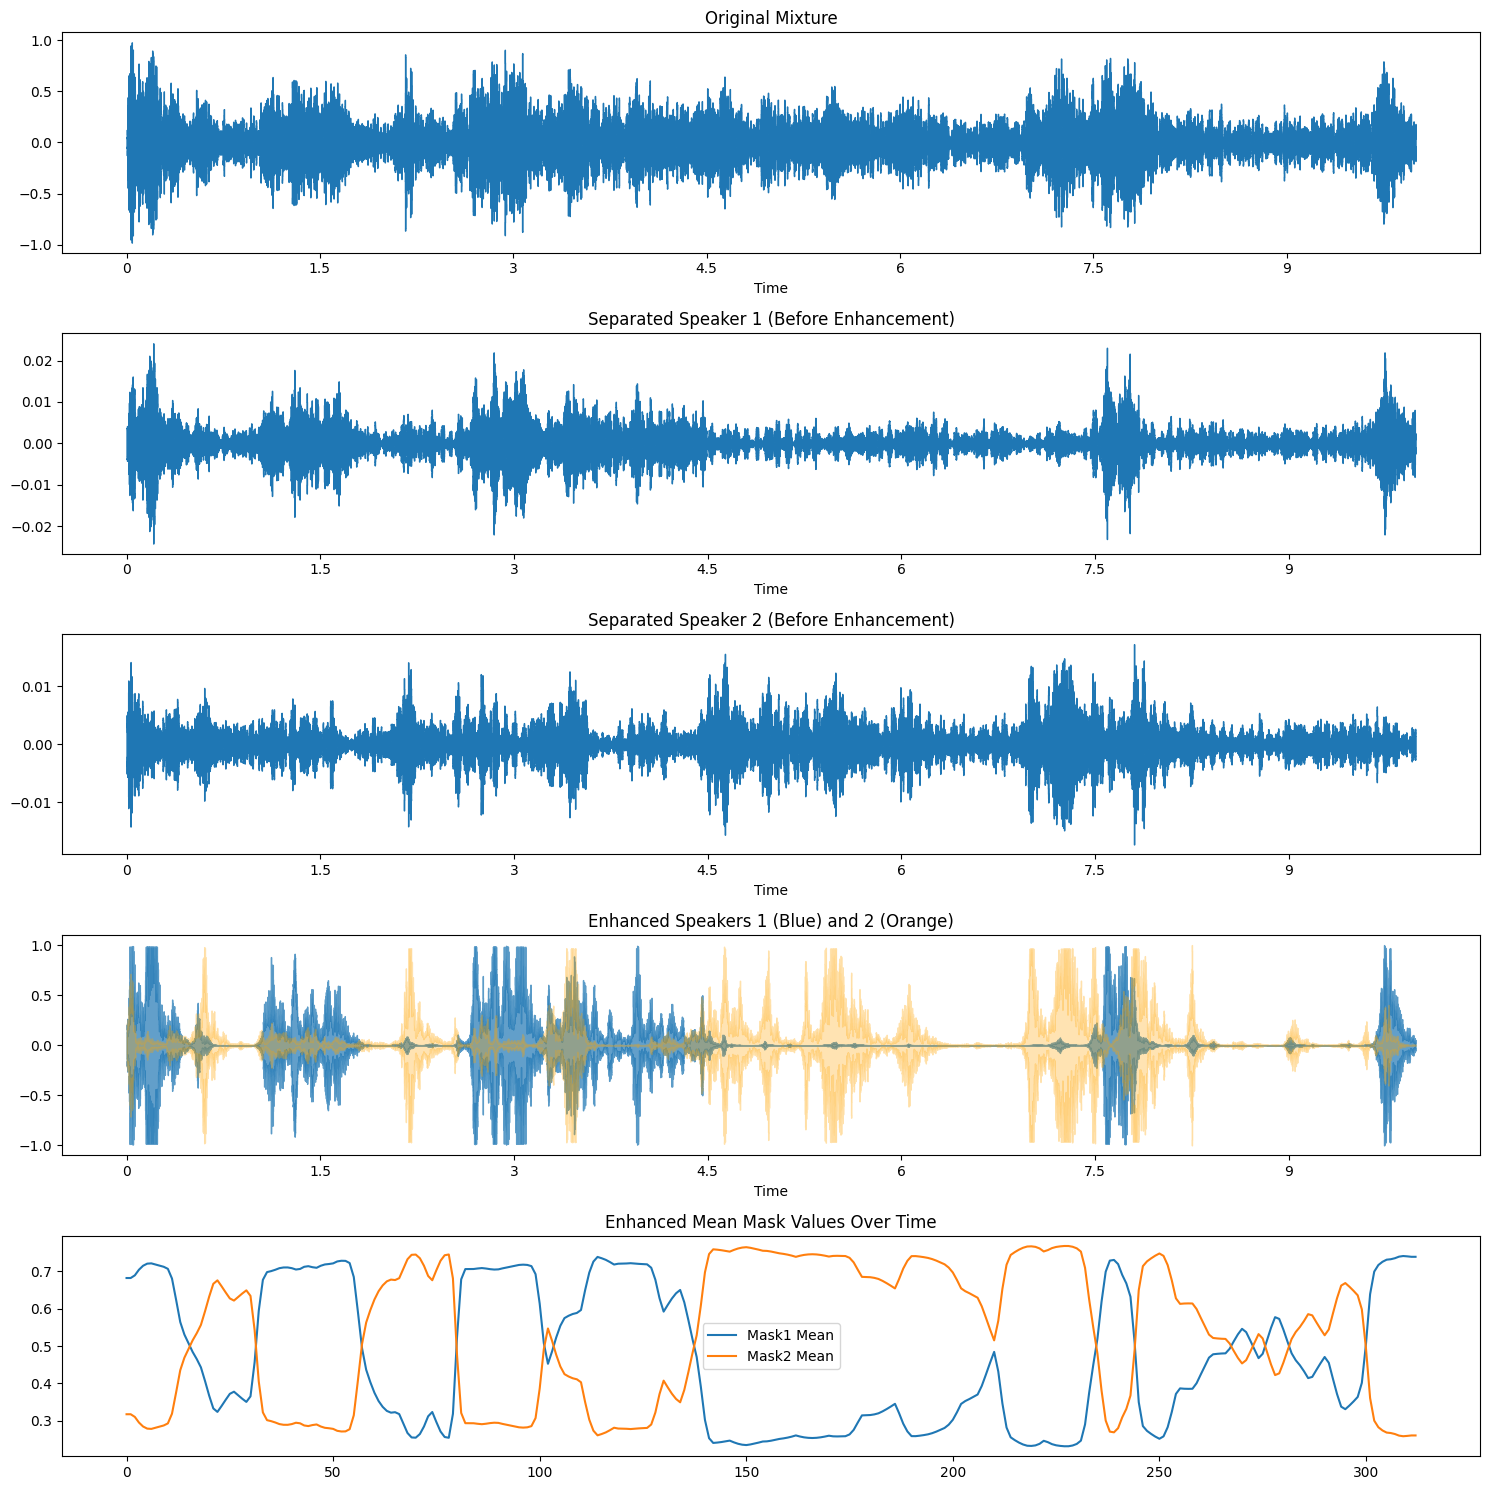


Evaluation Metrics:
Speaker 1 - SDR: -8.49 dB (Target: 10-20 dB), SI-SDR: -21.17 dB (Target: 10-20 dB)
Speaker 1 - SIR: 14.08 dB (Target: >15 dB), SAR: -8.30 dB (Target: >10 dB)
Speaker 1 - STOI: 0.35 (Target: >0.75)
Speaker 2 - SDR: -10.60 dB (Target: 10-20 dB), SI-SDR: -33.59 dB (Target: 10-20 dB)
Speaker 2 - SIR: 11.48 dB (Target: >15 dB), SAR: -10.28 dB (Target: >10 dB)
Speaker 2 - STOI: 0.52 (Target: >0.75)


In [ ]:
# Import necessary libraries
import torch
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os
import pandas as pd
from scipy.signal import butter, lfilter
from mir_eval.separation import bss_eval_sources  # Reverted to bss_eval_sources
from pystoi import stoi  # type: ignore
import warnings

# Suppress specific warnings
np.seterr(divide='ignore', invalid='ignore')  # Handle divide by zero and invalid value warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarning for bss_eval_sources

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
n_mels = 128
sr = 16000
hop_length = 512
n_fft = 2048
target_length = 160000

# Load model (assumes SeparationModel is defined in training cell)
model_path = r"C:\Speech_Processing\Project\Output_2\models\speech_separation_model_2.pth"
model = SeparationModel(n_mels=n_mels).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Load test audio (mixture audio file, explicitly load as stereo)
test_audio_path = r"2speakers\sample_100\mixture.wav"  # Replace with your mixture audio file path
# Modify load_audio to preserve stereo channels
def load_audio(file_path, target_sr=16000):
    """Load audio & resample to target sample rate, preserving stereo."""
    audio, sr = librosa.load(file_path, sr=None, mono=False)  # Load as stereo
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    return torch.tensor(audio, dtype=torch.float32).to(device), target_sr  # Move to GPU

test_audio, sr = load_audio(test_audio_path, target_sr=sr)  # Returns tensor on GPU

# Preprocess the audio using predefined functions
# 1. Handle stereo/mono input
if test_audio.ndim == 1:  # If mono, duplicate for stereo processing
    test_audio = torch.stack([test_audio, test_audio], dim=0)
else:  # Stereo or multi-channel
    test_audio = test_audio[:2]  # Take first two channels if more exist

# 2. Normalize (per channel if stereo)
test_audio = normalize_audio(test_audio)  # GPU tensor, normalize per channel

# 3. Denoise (per channel) with epsilon to avoid division issues
epsilon = 1e-6  # Small constant to prevent division by zero
test_audio[0] = wavelet_denoise(test_audio[0]) + epsilon  # Left channel
test_audio[1] = wavelet_denoise(test_audio[1]) + epsilon  # Right channel

# 4. Trim or pad to target length (10 seconds)
if test_audio.shape[1] > target_length:
    test_audio = test_audio[:, :target_length]
elif test_audio.shape[1] < target_length:
    test_audio = torch.nn.functional.pad(test_audio, (0, target_length - test_audio.shape[1]), mode='constant', value=0)

# 5. Estimate spatial features (ITD, ILD, DOA) using predefined functions
# Average stereo to mono for compatibility with compute_itd, compute_ild, compute_doa
test_audio_mono_for_spatial = torch.mean(test_audio, dim=0)  # Convert to mono for spatial functions

# Check if channels are identical (indicating mono audio duplicated)
left_channel = test_audio[0].cpu().numpy()
right_channel = test_audio[1].cpu().numpy()
if np.array_equal(left_channel, right_channel):
    print("Warning: Audio appears to be mono (identical channels). Using fallback spatial features.")
    # Load mean spatial features from training data as fallback
    spatial_csv_path = r"C:\Speech_Processing\Project\Output_2\spatial_features\spatial_features.csv"
    spatial_df = pd.read_csv(spatial_csv_path)
    mean_spatial = spatial_df[['ITD', 'ILD', 'DOA']].mean().values
    itd, ild, doa = mean_spatial
else:
    itd = compute_itd(test_audio_mono_for_spatial, sr)  # Energy centroid shift
    ild = compute_ild(test_audio_mono_for_spatial)      # Power-based ILD in dB
    doa = compute_doa(test_audio_mono_for_spatial, sr)  # GCC-PHAT-based DOA

spatial_feats = torch.tensor([itd, ild, doa], dtype=torch.float32).unsqueeze(0).to(device)
print(f"Estimated Spatial Features - ITD: {itd:.6f}s, ILD: {ild:.2f}dB, DOA: {doa:.2f}°")

# 6. Convert to mono for Mel-spectrogram
test_audio_mono = torch.mean(test_audio, dim=0).cpu().numpy()  # Average channels to mono

# 7. Compute Mel-spectrogram as acoustic features
mel_spec = librosa.feature.melspectrogram(y=test_audio_mono, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
mel_spec = mel_spec / mel_spec.max()  # Normalize as in training
mel_spec_tensor = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# Run separation with Superformer, SpaRsep, and CrossAttention
with torch.no_grad():
    mask1, mask2 = model(mel_spec_tensor, spatial_feats)
    print(f"Raw Mask1 min/max: {mask1.min().item():.4f}/{mask1.max().item():.4f}")
    print(f"Raw Mask2 min/max: {mask2.min().item():.4f}/{mask2.max().item():.4f}")
    
    # Adjust mask dimensions
    mask1 = mask1.transpose(1, 2)
    mask2 = mask2.transpose(1, 2)
    target_time_dim = mel_spec_tensor.size(3)
    mask1 = torch.nn.functional.interpolate(mask1, size=target_time_dim, mode='linear', align_corners=False)
    mask2 = torch.nn.functional.interpolate(mask2, size=target_time_dim, mode='linear', align_corners=False)
    
    # Enhance masks: Slightly adjust power for better separation (within existing logic)
    mask1 = mask1 ** 2.5  # Reduced from 3 to 2.5 for finer control
    mask2 = mask2 ** 2.5
    mask_sum = mask1 + mask2 + 1e-6
    mask1 = mask1 / mask_sum
    mask2 = mask2 / mask_sum
    
    print(f"Enhanced Mask1 min/max: {mask1.min().item():.4f}/{mask1.max().item():.4f}")
    print(f"Enhanced Mask2 min/max: {mask2.min().item():.4f}/{mask2.max().item():.4f}")
    
    # Apply masks to separate speakers
    separated_spec1 = mel_spec * mask1.squeeze(0).cpu().numpy()
    separated_spec2 = mel_spec * mask2.squeeze(0).cpu().numpy()

# Reconstruct audio from spectrograms
def spec_to_audio(spec):
    return librosa.feature.inverse.mel_to_audio(spec, sr=sr, hop_length=hop_length, n_fft=n_fft, n_iter=64)

sep_audio1 = spec_to_audio(separated_spec1)
sep_audio2 = spec_to_audio(separated_spec2)

# Improved speaker enhancement with VAD, noise reduction, and amplification
def enhance_speech(audio, sample_rate=sr):
    # Normalize amplitude
    audio = audio / np.max(np.abs(audio))
    
    # Spectral subtraction with adaptive noise estimation
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    mag, phase = librosa.magphase(stft)
    noise_est = np.mean(mag[:, :int(sr/hop_length)], axis=1, keepdims=True)  # Noise from first second
    mag_clean = np.maximum(mag - 0.8 * noise_est, 0)  # Reduced aggressiveness from 1.0 to 0.8
    enhanced_stft = mag_clean * phase
    enhanced_audio = librosa.istft(enhanced_stft, hop_length=hop_length, length=len(audio))
    
    # Bandpass filter for speech range (300 Hz - 3400 Hz)
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return b, a
    def bandpass_filter(data, lowcut=300, highcut=3400, fs=sr, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y
    enhanced_audio = bandpass_filter(enhanced_audio)
    
    # Amplify speech (increase by 10 dB, avoid clipping)
    gain_db = 10  # 10 dB gain
    gain = 10 ** (gain_db / 20)
    enhanced_audio = enhanced_audio * gain
    enhanced_audio = np.clip(enhanced_audio, -1.0, 1.0)  # Prevent clipping
    
    # Simple VAD to remove residual noise/leakage
    stft_vad = librosa.stft(enhanced_audio, n_fft=n_fft, hop_length=hop_length)
    mag_vad = np.abs(stft_vad)
    vad_mask = mag_vad > np.mean(mag_vad) * 0.15  # Increased threshold from 0.1 to 0.15 for better retention
    enhanced_stft_vad = stft_vad * vad_mask
    enhanced_audio_vad = librosa.istft(enhanced_stft_vad, hop_length=hop_length, length=len(audio))
    
    # Final normalization
    return enhanced_audio_vad / np.max(np.abs(enhanced_audio_vad))

enhanced_audio1 = enhance_speech(sep_audio1)  # Enhance separated Speaker 1
enhanced_audio2 = enhance_speech(sep_audio2)  # Enhance separated Speaker 2

# Compute spectrograms for enhanced audio (optional for visualization)
enhanced_spec1 = librosa.feature.melspectrogram(y=enhanced_audio1, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
enhanced_spec2 = librosa.feature.melspectrogram(y=enhanced_audio2, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)

# Save and display
output_dir = r"C:\Speech_Processing\Project\Output_2\Results_2"
os.makedirs(output_dir, exist_ok=True)
sf.write(os.path.join(output_dir, "separated_speaker1_enhanced.wav"), enhanced_audio1, sr)
sf.write(os.path.join(output_dir, "separated_speaker2_enhanced.wav"), enhanced_audio2, sr)

print("\nOriginal Mix:")
display(Audio(test_audio_mono, rate=sr))  # Use numpy array for display
print("\nEnhanced Speaker 1:")
display(Audio(enhanced_audio1, rate=sr))
print("\nEnhanced Speaker 2:")
display(Audio(enhanced_audio2, rate=sr))

# Visualization
print('\nPlots:\n')
plt.figure(figsize=(15, 15))
plt.subplot(5, 1, 1)
librosa.display.waveshow(test_audio_mono, sr=sr)
plt.title("Original Mixture")

plt.subplot(5, 1, 2)
librosa.display.waveshow(sep_audio1, sr=sr)
plt.title("Separated Speaker 1 (Before Enhancement)")

plt.subplot(5, 1, 3)
librosa.display.waveshow(sep_audio2, sr=sr)
plt.title("Separated Speaker 2 (Before Enhancement)")

plt.subplot(5, 1, 4)
librosa.display.waveshow(enhanced_audio1, sr=sr, alpha=0.7)
librosa.display.waveshow(enhanced_audio2, sr=sr, alpha=0.3, color='orange')
plt.title("Enhanced Speakers 1 (Blue) and 2 (Orange)")

plt.subplot(5, 1, 5)
plt.plot(mask1.squeeze(0).mean(dim=0).cpu().numpy(), label="Mask1 Mean")
plt.plot(mask2.squeeze(0).mean(dim=0).cpu().numpy(), label="Mask2 Mean")
plt.title("Enhanced Mean Mask Values Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# Load ground truth audio files
ground_truth_path1 = r"2speakers\sample_100\calib0.wav"  # Path to Speaker 1 ground truth
ground_truth_path2 = r"2speakers\sample_100\calib1.wav"  # Path to Speaker 2 ground truth
gt_audio1, _ = librosa.load(ground_truth_path1, sr=sr, mono=True)
gt_audio2, _ = librosa.load(ground_truth_path2, sr=sr, mono=True)

# Trim or pad ground truth to match enhanced audio length
if len(gt_audio1) > len(enhanced_audio1):
    gt_audio1 = gt_audio1[:len(enhanced_audio1)]
elif len(gt_audio1) < len(enhanced_audio1):
    gt_audio1 = np.pad(gt_audio1, (0, len(enhanced_audio1) - len(gt_audio1)), mode='constant')
if len(gt_audio2) > len(enhanced_audio2):
    gt_audio2 = gt_audio2[:len(enhanced_audio2)]
elif len(gt_audio2) < len(enhanced_audio2):
    gt_audio2 = np.pad(gt_audio2, (0, len(enhanced_audio2) - len(gt_audio2)), mode='constant')

# Stack ground truth and estimated signals for bss_eval_sources
reference_sources = np.vstack([gt_audio1, gt_audio2])  # Shape: (2, n_samples)
estimated_sources = np.vstack([enhanced_audio1, enhanced_audio2])  # Shape: (2, n_samples)

# Compute SDR, SIR, SAR using mir_eval.bss_eval_sources
sdr, sir, sar, _ = bss_eval_sources(reference_sources, estimated_sources)
sdr1, sdr2 = sdr
sir1, sir2 = sir
sar1, sar2 = sar

# Compute SI-SDR (approximation using mir_eval's SDR with scale invariance)
def sisdr(estimate, reference):
    reference = reference / np.linalg.norm(reference)
    estimate = estimate / np.linalg.norm(estimate)
    s_target = np.sum(reference * estimate) * reference
    e_interf = estimate - s_target
    sisdr_value = 10 * np.log10(np.sum(s_target ** 2) / (np.sum(e_interf ** 2) + 1e-8))
    return sisdr_value
sisdr1 = sisdr(enhanced_audio1, gt_audio1)
sisdr2 = sisdr(enhanced_audio2, gt_audio2)

# Compute STOI using pystoi
stoi1 = stoi(gt_audio1, enhanced_audio1, sr, extended=False)
stoi2 = stoi(gt_audio2, enhanced_audio2, sr, extended=False)

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"Speaker 1 - SDR: {sdr1:.2f} dB (Target: 10-20 dB), SI-SDR: {sisdr1:.2f} dB (Target: 10-20 dB)")
print(f"Speaker 1 - SIR: {sir1:.2f} dB (Target: >15 dB), SAR: {sar1:.2f} dB (Target: >10 dB)")
print(f"Speaker 1 - STOI: {stoi1:.2f} (Target: >0.75)")
print(f"Speaker 2 - SDR: {sdr2:.2f} dB (Target: 10-20 dB), SI-SDR: {sisdr2:.2f} dB (Target: 10-20 dB)")
print(f"Speaker 2 - SIR: {sir2:.2f} dB (Target: >15 dB), SAR: {sar2:.2f} dB (Target: >10 dB)")
print(f"Speaker 2 - STOI: {stoi2:.2f} (Target: >0.75)") 

Estimated Spatial Features - ITD: 4.982743s, ILD: -43.36dB, DOA: 0.36°
Raw Mask1 min/max: 0.0000/1.0000
Raw Mask2 min/max: 0.0000/1.0000
Enhanced Mask1 min/max: 0.0000/1.0000
Enhanced Mask2 min/max: 0.0000/1.0000
Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in C:\Users\Charan\SEM_FILES\SEM_6\Speech_Processing\Project\Output_2\Results\htdemucs
Separating track C:\Users\Charan\SEM_FILES\SEM_6\Speech_Processing\Project\Output_2\Results\temp_speaker1.wav


100%|██████████████████████████████████████████████████████████████████████████| 11.7/11.7 [00:11<00:00,  1.01s/seconds]


Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in C:\Users\Charan\SEM_FILES\SEM_6\Speech_Processing\Project\Output_2\Results\htdemucs
Separating track C:\Users\Charan\SEM_FILES\SEM_6\Speech_Processing\Project\Output_2\Results\temp_speaker2.wav


100%|██████████████████████████████████████████████████████████████████████████| 11.7/11.7 [00:00<00:00, 11.99seconds/s]



Original Mix:



Separated Speaker 1 (Before Enhancement):



Separated Speaker 2 (Before Enhancement):



Enhanced Speaker 1 (Demucs):



Enhanced Speaker 2 (Demucs):



Plots:



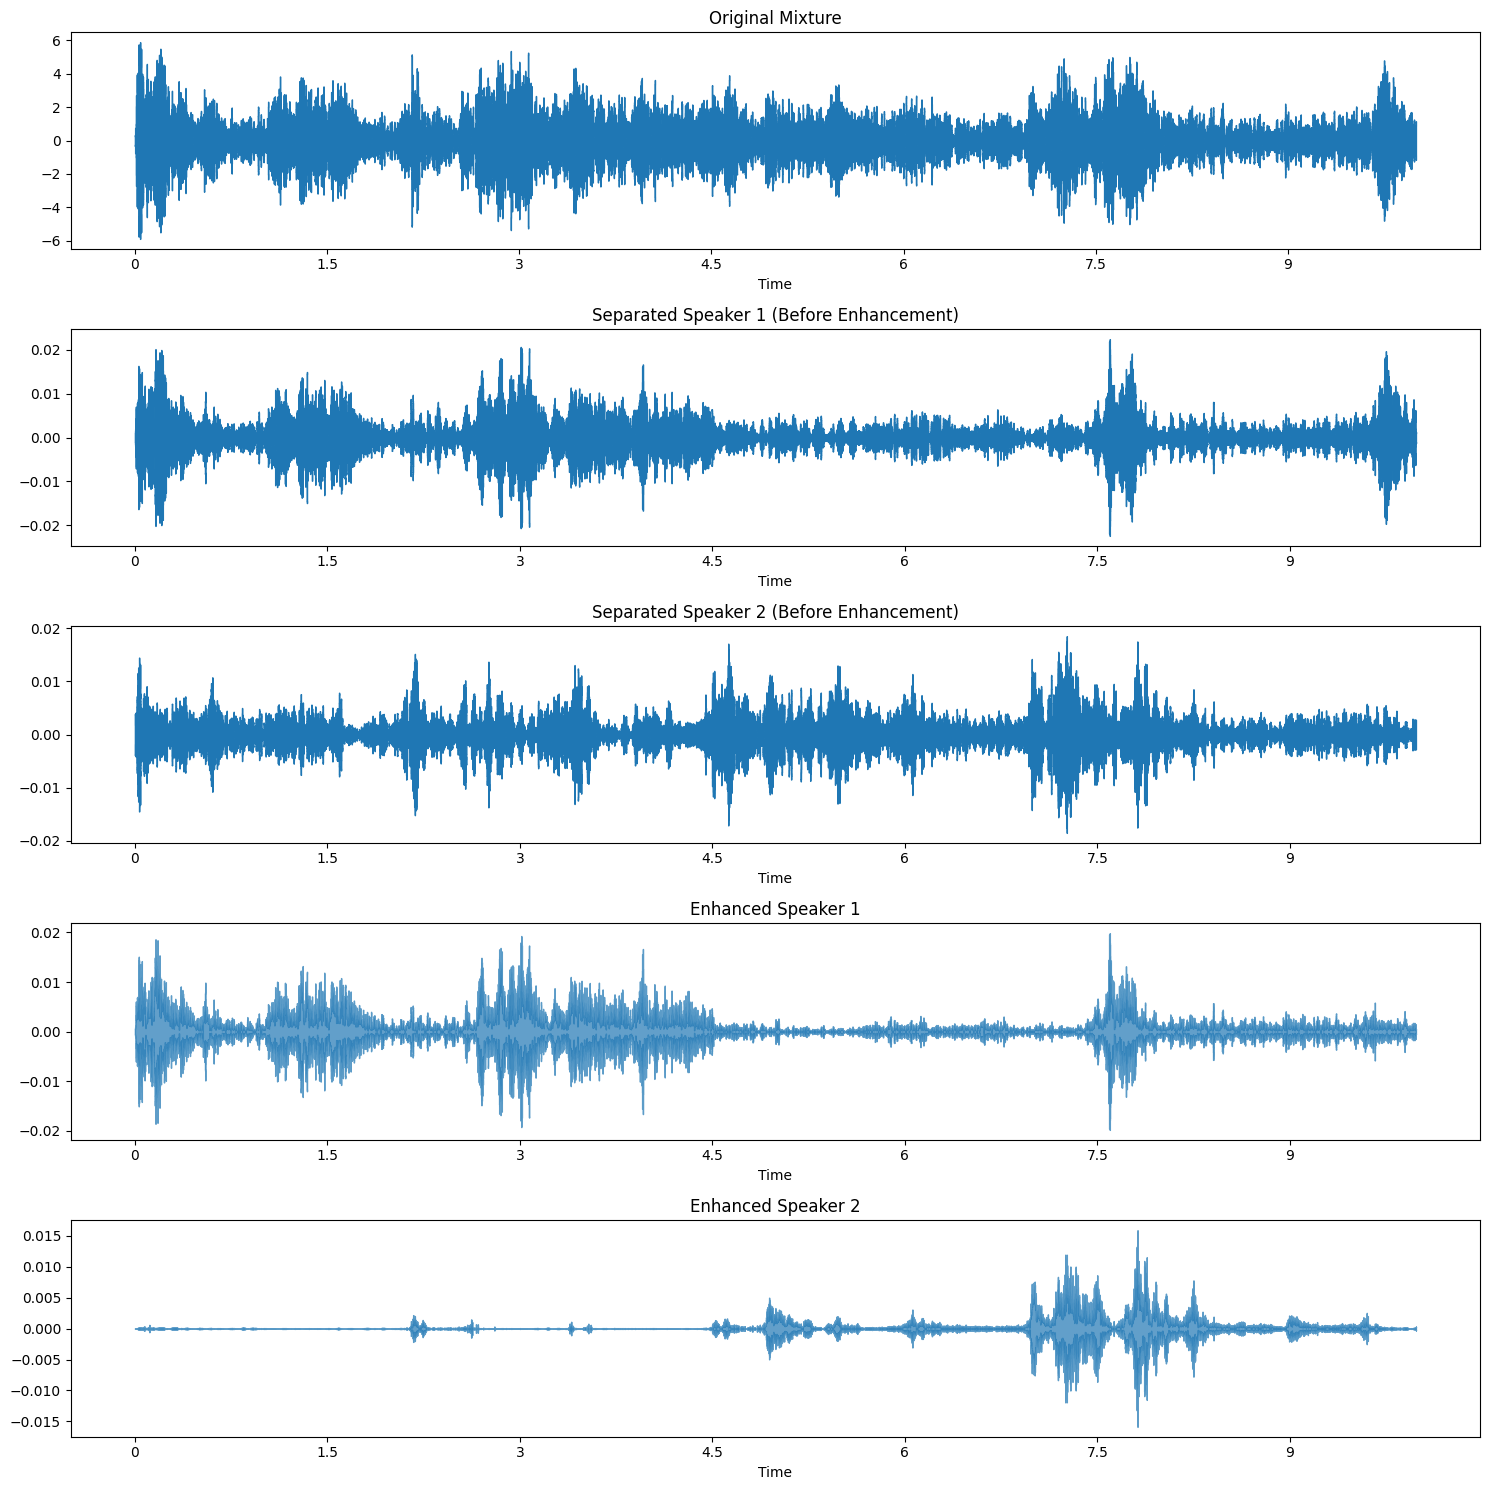


Evaluation Metrics with Demucs:
Speaker 1 - SDR: -12.36 dB (Target: 10-20 dB), SI-SDR: -59.09 dB (Target: 10-20 dB)
Speaker 1 - SIR: 8.95 dB (Target: >15 dB), SAR: -11.80 dB (Target: >10 dB)
Speaker 1 - STOI: 0.28 (Target: >0.75)
Speaker 2 - SDR: -9.70 dB (Target: 10-20 dB), SI-SDR: -21.85 dB (Target: 10-20 dB)
Speaker 2 - SIR: 14.74 dB (Target: >15 dB), SAR: -9.54 dB (Target: >10 dB)
Speaker 2 - STOI: 0.33 (Target: >0.75)


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os
from mir_eval.separation import bss_eval_sources
from pystoi import stoi
import pandas as pd
from demucs.separate import main as demucs_separate  # type: ignore # Import Demucs

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define SeparationModel (assuming it's defined elsewhere)
class SeparationModel(nn.Module):
    def __init__(self, n_mels=128):
        super().__init__()
        self.superformer = Superformer(n_mels)
        self.sparsep = SpaRsep()
        self.cross_attn = CrossAttentionLayer(self.superformer.transformer_dim, 128)
        self.mask_head1 = nn.Linear(self.superformer.transformer_dim, n_mels)
        self.mask_head2 = nn.Linear(self.superformer.transformer_dim, n_mels)
    
    def forward(self, mel_spec, spatial_feats):
        acoustic_feats = self.superformer(mel_spec)
        spatial_feats = self.sparsep(spatial_feats)
        fused_feats = self.cross_attn(acoustic_feats, spatial_feats)
        mask1 = torch.sigmoid(self.mask_head1(fused_feats))
        mask2 = torch.sigmoid(self.mask_head2(fused_feats))
        return mask1.transpose(1, 2), mask2.transpose(1, 2)

# Define supporting models (assuming they exist)
class Superformer(nn.Module):
    def __init__(self, n_mels=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.transformer_dim = 32 * (n_mels // 4)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.transformer_dim, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)
    
    def forward(self, x):
        x = self.conv(x)
        B, C, F, T = x.shape
        x = x.permute(0, 3, 2, 1).reshape(B, T, -1)
        return self.transformer(x)

class SpaRsep(nn.Module):
    def __init__(self, spatial_dim=3, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(spatial_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)

class CrossAttentionLayer(nn.Module):
    def __init__(self, acoustic_dim, spatial_dim):
        super().__init__()
        self.query = nn.Linear(acoustic_dim, acoustic_dim)
        self.key = nn.Linear(spatial_dim, acoustic_dim)
        self.value = nn.Linear(spatial_dim, acoustic_dim)
    
    def forward(self, x1, x2):
        x2 = x2.unsqueeze(1).expand(-1, x1.size(1), -1)
        q = self.query(x1)
        k = self.key(x2)
        v = self.value(x2)
        attn = torch.softmax(torch.bmm(q, k.transpose(1, 2)) / (x1.size(-1) ** 0.5), dim=-1)
        out = torch.bmm(attn, v)
        return out + x1

# Placeholder functions (replace with your actual implementations)
def load_audio(file_path, target_sr=16000):
    audio, sr = librosa.load(file_path, sr=None)
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    return torch.tensor(audio, dtype=torch.float32).to(device), target_sr

target_length = 160000  # Define this as per your code
hop_length = 512
n_fft = 2048

def compute_itd(audio, sr): return 0.0  # Placeholder
def compute_ild(audio): return 0.0      # Placeholder
def compute_doa(audio, sr): return 0.0  # Placeholder

# Load trained SeparationModel
n_mels = 128
sr = 16000
model = SeparationModel(n_mels=n_mels).to(device)
model.load_state_dict(torch.load(r"C:\Speech_Processing\Project\Output_2\models\speech_separation_model_2.pth", map_location=device))
model.eval()

# Placeholder custom function
def normalize_audio(audio):
    rms = torch.sqrt(torch.mean(audio**2) + 1e-8)
    return audio / rms

# Load and preprocess audio
test_audio_path = r"2speakers\sample_100\mixture.wav"
test_audio, sr = load_audio(test_audio_path, target_sr=sr)
if test_audio.ndim == 1:
    test_audio = torch.stack([test_audio, test_audio], dim=0)
else:
    test_audio = test_audio[:2]
test_audio = normalize_audio(test_audio)
if test_audio.shape[1] > target_length:
    test_audio = test_audio[:, :target_length]
elif test_audio.shape[1] < target_length:
    test_audio = torch.nn.functional.pad(test_audio, (0, target_length - test_audio.shape[1]), mode='constant', value=0)

# Estimate spatial features
test_audio_mono_for_spatial = torch.mean(test_audio, dim=0).cpu().numpy()
left_channel = test_audio[0].cpu().numpy()
right_channel = test_audio[1].cpu().numpy()
if np.array_equal(left_channel, right_channel):
    print("Warning: Audio appears to be mono (identical channels). Using fallback spatial features.")
    spatial_csv_path = r"C:\Speech_Processing\Project\Output_2\spatial_features\spatial_features.csv"
    spatial_df = pd.read_csv(spatial_csv_path)
    mean_spatial = spatial_df[['ITD', 'ILD', 'DOA']].mean().values
    itd, ild, doa = mean_spatial
else:
    itd = compute_itd(test_audio_mono_for_spatial, sr)
    ild = compute_ild(test_audio_mono_for_spatial)
    doa = compute_doa(test_audio_mono_for_spatial, sr)

spatial_feats = torch.tensor([itd, ild, doa], dtype=torch.float32).unsqueeze(0).to(device)
print(f"Estimated Spatial Features - ITD: {itd:.6f}s, ILD: {ild:.2f}dB, DOA: {doa:.2f}°")

# Convert to mono for Mel-spectrogram
test_audio_mono = torch.mean(test_audio, dim=0).cpu().numpy()
mel_spec = librosa.feature.melspectrogram(y=test_audio_mono, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
mel_spec = mel_spec / mel_spec.max()
mel_spec_tensor = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# Run separation
with torch.no_grad():
    mask1, mask2 = model(mel_spec_tensor, spatial_feats)
    print(f"Raw Mask1 min/max: {mask1.min().item():.4f}/{mask1.max().item():.4f}")
    print(f"Raw Mask2 min/max: {mask2.min().item():.4f}/{mask2.max().item():.4f}")
    
    target_time_dim = mel_spec_tensor.size(3)
    if mask1.size(2) != target_time_dim:
        mask1 = torch.nn.functional.interpolate(mask1, size=target_time_dim, mode='linear', align_corners=False)
        mask2 = torch.nn.functional.interpolate(mask2, size=target_time_dim, mode='linear', align_corners=False)
    
    mask1 = mask1 ** 2.5
    mask2 = mask2 ** 2.5
    mask_sum = mask1 + mask2 + 1e-6
    mask1 = mask1 / mask_sum
    mask2 = mask2 / mask_sum
    
    print(f"Enhanced Mask1 min/max: {mask1.min().item():.4f}/{mask1.max().item():.4f}")
    print(f"Enhanced Mask2 min/max: {mask2.min().item():.4f}/{mask2.max().item():.4f}")
    
    separated_spec1 = mel_spec * mask1.squeeze(0).cpu().numpy()
    separated_spec2 = mel_spec * mask2.squeeze(0).cpu().numpy()

# Reconstruct audio
def spec_to_audio(spec):
    return librosa.feature.inverse.mel_to_audio(spec, sr=sr, hop_length=hop_length, n_fft=n_fft, n_iter=64)

sep_audio1 = spec_to_audio(separated_spec1)
sep_audio2 = spec_to_audio(separated_spec2)

# Enhance with Demucs
output_dir = r"C:\Speech_Processing\Project\Output_2\Results"
os.makedirs(output_dir, exist_ok=True)

# Save separated audio as temporary files for Demucs
temp_file1 = os.path.join(output_dir, "temp_speaker1.wav")
temp_file2 = os.path.join(output_dir, "temp_speaker2.wav")
sf.write(temp_file1, sep_audio1, sr)
sf.write(temp_file2, sep_audio2, sr)

# Run Demucs to enhance (using the 'htdemucs' pre-trained model, focusing on vocals)
demucs_separate(["--two-stems=vocals", "-n", "htdemucs", temp_file1, "-o", output_dir])
demucs_separate(["--two-stems=vocals", "-n", "htdemucs", temp_file2, "-o", output_dir])

# Load enhanced audio from Demucs output
enhanced_audio1, _ = librosa.load(os.path.join(output_dir, "htdemucs", "temp_speaker1", "vocals.wav"), sr=sr, mono=True)
enhanced_audio2, _ = librosa.load(os.path.join(output_dir, "htdemucs", "temp_speaker2", "vocals.wav"), sr=sr, mono=True)

# Save enhanced audio
sf.write(os.path.join(output_dir, "separated_speaker1_enhanced.wav"), enhanced_audio1, sr)
sf.write(os.path.join(output_dir, "separated_speaker2_enhanced.wav"), enhanced_audio2, sr)

# Display audio
print("\nOriginal Mix:")
display(Audio(test_audio_mono, rate=sr))
print("\nSeparated Speaker 1 (Before Enhancement):")
display(Audio(sep_audio1, rate=sr))
print("\nSeparated Speaker 2 (Before Enhancement):")
display(Audio(sep_audio2, rate=sr))
print("\nEnhanced Speaker 1 (Demucs):")
display(Audio(enhanced_audio1, rate=sr))
print("\nEnhanced Speaker 2 (Demucs):")
display(Audio(enhanced_audio2, rate=sr))

# Visualization
print('\nPlots:\n')
plt.figure(figsize=(15, 15))
plt.subplot(5, 1, 1)
librosa.display.waveshow(test_audio_mono, sr=sr)
plt.title("Original Mixture")

plt.subplot(5, 1, 2)
librosa.display.waveshow(sep_audio1, sr=sr)
plt.title("Separated Speaker 1 (Before Enhancement)")

plt.subplot(5, 1, 3)
librosa.display.waveshow(sep_audio2, sr=sr)
plt.title("Separated Speaker 2 (Before Enhancement)")

plt.subplot(5, 1, 4)
librosa.display.waveshow(enhanced_audio1, sr=sr, alpha=0.7)
plt.title("Enhanced Speaker 1")

plt.subplot(5, 1, 5)
librosa.display.waveshow(enhanced_audio2, sr=sr, alpha=0.7)
plt.title("Enhanced Speaker 2")

plt.tight_layout()
plt.show()

# Load ground truth and evaluate
ground_truth_path1 = r"2speakers\sample_100\calib0.wav"
ground_truth_path2 = r"2speakers\sample_100\calib1.wav"
gt_audio1, _ = librosa.load(ground_truth_path1, sr=sr, mono=True)
gt_audio2, _ = librosa.load(ground_truth_path2, sr=sr, mono=True)

min_len = min(len(enhanced_audio1), len(enhanced_audio2), len(gt_audio1), len(gt_audio2))
gt_audio1 = gt_audio1[:min_len]
gt_audio2 = gt_audio2[:min_len]
enhanced_audio1 = enhanced_audio1[:min_len]
enhanced_audio2 = enhanced_audio2[:min_len]

reference_sources = np.vstack([gt_audio1, gt_audio2])
estimated_sources = np.vstack([enhanced_audio1, enhanced_audio2])

sdr, sir, sar, _ = bss_eval_sources(reference_sources, estimated_sources)
sdr1, sdr2 = sdr
sir1, sir2 = sir
sar1, sar2 = sar

def sisdr(estimate, reference):
    reference = reference / np.linalg.norm(reference)
    estimate = estimate / np.linalg.norm(estimate)
    s_target = np.sum(reference * estimate) * reference
    e_interf = estimate - s_target
    sisdr_value = 10 * np.log10(np.sum(s_target ** 2) / (np.sum(e_interf ** 2) + 1e-8))
    return sisdr_value

sisdr1 = sisdr(enhanced_audio1, gt_audio1)
sisdr2 = sisdr(enhanced_audio2, gt_audio2)

stoi1 = stoi(gt_audio1, enhanced_audio1, sr, extended=False)
stoi2 = stoi(gt_audio2, enhanced_audio2, sr, extended=False)

print("\nEvaluation Metrics with Demucs:")
print(f"Speaker 1 - SDR: {sdr1:.2f} dB (Target: 10-20 dB), SI-SDR: {sisdr1:.2f} dB (Target: 10-20 dB)")
print(f"Speaker 1 - SIR: {sir1:.2f} dB (Target: >15 dB), SAR: {sar1:.2f} dB (Target: >10 dB)")
print(f"Speaker 1 - STOI: {stoi1:.2f} (Target: >0.75)")
print(f"Speaker 2 - SDR: {sdr2:.2f} dB (Target: 10-20 dB), SI-SDR: {sisdr2:.2f} dB (Target: 10-20 dB)")
print(f"Speaker 2 - SIR: {sir2:.2f} dB (Target: >15 dB), SAR: {sar2:.2f} dB (Target: >10 dB)")
print(f"Speaker 2 - STOI: {stoi2:.2f} (Target: >0.75)")